# Guide on how to use the backtester

In [1]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [2]:
import math

def norm_cdf(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2)

import numpy as np

# Bisection method for implied volatility
def bisection_implied_vol(S, K, T, r, market_price, tol=1e-6, max_iter=100):
    # Initial bounds for volatility
    lower_bound = 1e-6
    upper_bound = 5.0
    
    for i in range(max_iter):
        # Midpoint for the current bounds
        sigma_mid = (lower_bound + upper_bound) / 2
        
        # Calculate the Black-Scholes price for this sigma
        option_price = black_scholes_call_price(S, K, T, r, sigma_mid)
        
        # If the price is close enough to the market price, return this sigma
        if abs(option_price - market_price) < tol:
            return sigma_mid
        
        # If the option price is higher than the market price, adjust the upper bound
        if option_price > market_price:
            upper_bound = sigma_mid
        else:
            # Otherwise, adjust the lower bound
            lower_bound = sigma_mid
    
    # Return the midpoint as the implied volatility
    return (lower_bound + upper_bound) / 2

In [3]:
def size_function(z, edge_0, edge_max, max_position = 50):
    z = np.array(z)
    direction = np.where(z > 0, -1, 1)
    abs_z = np.abs(z)
    size = np.where(
        abs_z <= edge_0,
        0,
        np.where(
            abs_z >= edge_max,
            max_position,
            max_position * ((abs_z - edge_0) / (edge_max - edge_0)) ** 2
        )
    )
    return direction * size

def exit_size_function(z, edge_0, edge_max, max_position = 50):
    # Positive quadratic function with points (0, 0) and (-2, 50)
    if z <= 0:
        if z >= -edge_0:
            return 0
        elif z <= -edge_max:
            return max_position
            
        a = -max_position/(edge_max - edge_0)**2
        return a * (z + edge_max)**2 + max_position
    else:
        if z <= edge_0:
            return 0
        elif z >= edge_max:
            return -max_position
        a = max_position/(edge_max - edge_0)**2
        return a * (z-edge_max)**2 - max_position


In [17]:
class Trader:
    def __init__(self):
        self.position_limit = {"KELP": 50, "RAINFOREST_RESIN": 50}
        self.past_iv = []

    def run(self, state: TradingState):
        result = {}
        volcano_s0 = 0
        option_mid = 0
        for product in state.order_depths:
            orders: list[Order] = []
            order_depth: OrderDepth = state.order_depths[product]
            if product == "VOLCANIC_ROCK":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask1, best_ask_amount1 = list(order_depth.sell_orders.items())[0]
                    best_bid1, best_bid_amount1 = list(order_depth.buy_orders.items())[0]
                    volcano_s0 = (best_ask1 + best_bid1)/2
                
            if product == "VOLCANIC_ROCK_VOUCHER_10000":
                if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
                    best_ask, best_ask_amount = list(order_depth.sell_orders.items())[0]
                    best_bid, best_bid_amount = list(order_depth.buy_orders.items())[0]
                    option_mid = (best_ask + best_bid)/2

        if volcano_s0 == 0 or option_mid == 0:
            pass
        else:
            T = (8 - state.timestamp/1000000)/365   
            print(state.timestamp)
            print(f"Diff: {state.timestamp/1000000}")
            print(T)
            iv = bisection_implied_vol(volcano_s0, 10000, T, 0, option_mid) * 100
            
            self.past_iv.append(iv)
            if len(self.past_iv) < 400: 
                avg = pd.Series(self.past_iv).mean()
            else:
                avg = pd.Series(self.past_iv[-400:]).mean()
                
            z_mid = iv - avg
            edge_0 = 0.4
            edge_max = 1.5
            
            edge_max_retreet = 1.3
            edge_0_retreet = 0.2
            position_max = 200
            position_10000 = state.position.get("VOLCANIC_ROCK_VOUCHER_10000", 0)

            
            pos_buy = size_function(z_mid, edge_0, edge_max, position_max)
            pos_sell = exit_size_function(z_mid, edge_0_retreet, edge_max_retreet, position_max)

            available_sell = abs(best_bid_amount)
            available_buy = abs(best_ask_amount)


            print(f"Position: {position_10000}")
            
            if z_mid > 0:               
                if pos_buy <= position_10000:
                    target_position = pos_buy
                    trade_needed = int(target_position - position_10000)
                    trade_multiplier = min(abs(trade_needed), available_buy, abs(best_bid_amount))
                    result['VOLCANIC_ROCK_VOUCHER_10000'] = [Order('VOLCANIC_ROCK_VOUCHER_10000', best_bid, -trade_multiplier)]
                else:
                    target_position = max(pos_sell, min(position_10000, 0))
                    trade_needed = int(target_position - position_10000)
                    trade_multiplier = min(abs(trade_needed), available_sell, abs(best_ask_amount))
                    result['VOLCANIC_ROCK_VOUCHER_10000'] = [Order('VOLCANIC_ROCK_VOUCHER_10000', best_ask, trade_multiplier)]
      
            elif z_mid < 0:
                if pos_buy >= position_10000:
                    target_position = pos_buy
                    trade_needed = int(target_position - position_10000)
                    trade_multiplier = min(abs(trade_needed), available_sell,abs(best_ask_amount))
                    result['VOLCANIC_ROCK_VOUCHER_10000'] = [Order('VOLCANIC_ROCK_VOUCHER_10000', best_ask, trade_multiplier)]
    
                else:
                    target_position = min(pos_sell, max(position_10000, 0))
                    trade_needed = int(target_position - position_10000)
                    trade_multiplier = min(abs(trade_needed), available_buy,abs(best_bid_amount))
                    result['VOLCANIC_ROCK_VOUCHER_10000'] = [Order('VOLCANIC_ROCK_VOUCHER_10000', best_bid, -trade_multiplier)]

        print(result)
        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData

Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [18]:
market_data_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_0.csv"), sep=";")
market_data_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_1.csv"), sep=";")
market_data_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_2.csv"), sep=";")

trades_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_0.csv"), sep=";")
trades_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_1.csv"), sep=";")
trades_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_2.csv"), sep=";")



# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_3_all3days = concatenate_historical_data([market_data_round_3_day_0, market_data_round_3_day_1, market_data_round_3_day_2])
trades_round_3_all3days = concatenate_historical_data([trades_round_3_day_0, trades_round_3_day_1, market_data_round_3_day_2])

Lets run the backtester

In [21]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    # "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    # "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    # "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    # "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    # "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    #"RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    # "CROISSANTS": 250,
    # "DJEMBES": 60,
    # "JAMS": 350,
    # "KELP": 50,
    # "PICNIC_BASKET1": 60,
    # "PICNIC_BASKET2": 100,
    #"RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
     "VOLCANIC_ROCK": 400,
    "VOLCANIC_ROCK_VOUCHER_10000": 200,
    "VOLCANIC_ROCK_VOUCHER_10250": 200,
    "VOLCANIC_ROCK_VOUCHER_10500": 200,
    "VOLCANIC_ROCK_VOUCHER_9500": 200,
    "VOLCANIC_ROCK_VOUCHER_9750": 200,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object
trader = Trader()

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_3_all3days, trades_round_3_all3days, output_log_filename = 'options_r3v2.log')


bt.run()


# double layer dictionary.
resinpnl = bt.pnl()["spreadcrossing"]["VOLCANIC_ROCK_VOUCHER_10000"]
totalpnl = bt.pnl()["spreadcrossing"]["total"]
resinpnl, totalpnl, bt.pnl()

0
Diff: 0.0
0.021917808219178082
Position: 0
{}
100
Diff: 0.0001
0.021917534246575342
Position: 0
{'VOLCANIC_ROCK_VOUCHER_10000': [(VOLCANIC_ROCK_VOUCHER_10000, 515, -13)]}
200
Diff: 0.0002
0.021917260273972602
Position: -13
{'VOLCANIC_ROCK_VOUCHER_10000': [(VOLCANIC_ROCK_VOUCHER_10000, 517, 13)]}
300
Diff: 0.0003
0.021916986301369863
Position: 0
{'VOLCANIC_ROCK_VOUCHER_10000': [(VOLCANIC_ROCK_VOUCHER_10000, 521, 0)]}
400
Diff: 0.0004
0.021916712328767123
Position: 0
{'VOLCANIC_ROCK_VOUCHER_10000': [(VOLCANIC_ROCK_VOUCHER_10000, 513, 7)]}
500
Diff: 0.0005
0.021916438356164383
Position: 7
{'VOLCANIC_ROCK_VOUCHER_10000': [(VOLCANIC_ROCK_VOUCHER_10000, 510, -8)]}
600
Diff: 0.0006
0.021916164383561643
Position: -1
{'VOLCANIC_ROCK_VOUCHER_10000': [(VOLCANIC_ROCK_VOUCHER_10000, 507, 15)]}
700
Diff: 0.0007
0.021915890410958903
Position: 14
{'VOLCANIC_ROCK_VOUCHER_10000': [(VOLCANIC_ROCK_VOUCHER_10000, 507, -14)]}
800
Diff: 0.0008
0.021915616438356166
Position: 0
{'VOLCANIC_ROCK_VOUCHER_10000'

(129133.0,
 129133.0,
 {'spreadcrossing': {'VOLCANIC_ROCK_VOUCHER_10500': 0.0,
   'VOLCANIC_ROCK_VOUCHER_10000': 129133.0,
   'VOLCANIC_ROCK_VOUCHER_9750': 0.0,
   'VOLCANIC_ROCK_VOUCHER_9500': 0.0,
   'VOLCANIC_ROCK_VOUCHER_10250': 0.0,
   'VOLCANIC_ROCK': 0.0,
   'total': 129133.0},
  'midpoint': {'VOLCANIC_ROCK_VOUCHER_10500': 0.0,
   'VOLCANIC_ROCK_VOUCHER_10000': 231376.5,
   'VOLCANIC_ROCK_VOUCHER_9750': 0.0,
   'VOLCANIC_ROCK_VOUCHER_9500': 0.0,
   'VOLCANIC_ROCK_VOUCHER_10250': 0.0,
   'VOLCANIC_ROCK': 0.0,
   'total': 231376.5}})

You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.

Let's look at some metrics now.

Note:
- `get_metric` function is now deleted.
- `bt.pnl` is also deleted.
- If you want metrics, use `calculate_metrics(product)`.

Old way:
    bt.get_metric('midpoint_sharpe', 'KELP')

New way:
    metrics = bt.calculate_metrics('KELP')
    metric = metrics['midpoint_sharpe']

Available metrics: dict_keys(['timestamp', 'spreadcrossing_pnl', 'spreadcrossing_final_pnl', 'spreadcrossing_sharpe', 'spreadcrossing_pnl_bps', 'midpoint_pnl', 'midpoint_final_pnl', 'midpoint_sharpe', 'midpoint_pnl_bps'])


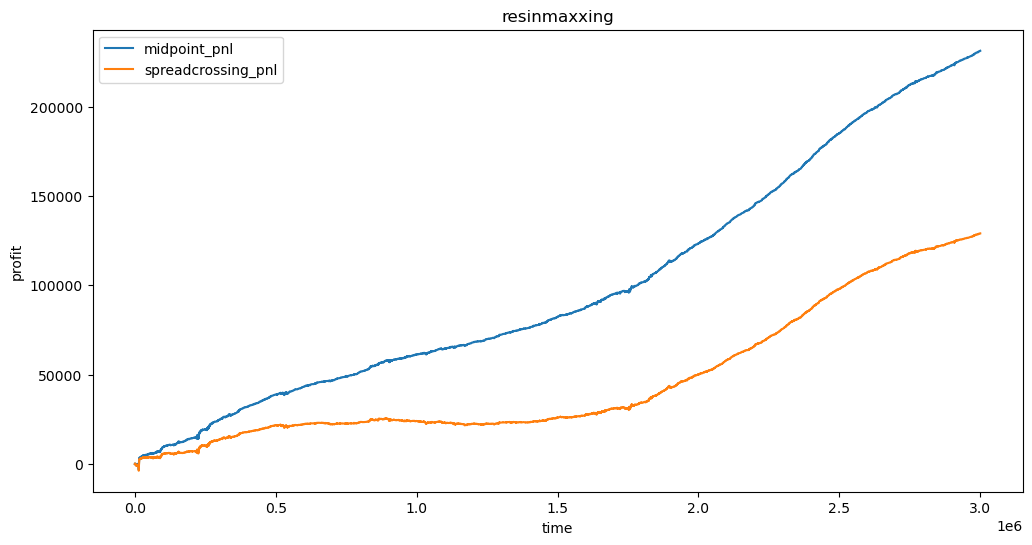

In [22]:
metrics = bt.calculate_metrics("VOLCANIC_ROCK_VOUCHER_10000")

print(f"Available metrics: {metrics.keys()}")

# metrics['timestamp'] is provided for convenience.
# this should line up with metrics['midpoint_pnl'] and metrics['spreadcrossing_pnl'] (i.e. same shape)

plt.figure(figsize=(12, 6))
plt.plot(metrics["timestamp"], metrics["midpoint_pnl"], label="midpoint_pnl")
plt.plot(metrics["timestamp"], metrics["spreadcrossing_pnl"], label="spreadcrossing_pnl")
plt.title("resinmaxxing")
plt.xlabel("time")
plt.ylabel("profit")
plt.legend()